In [ ]:
!unzip -qq skku-2024-1-machine-learning-third-project.zip -d ./data

In [ ]:
import os
from os import listdir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split

import cv2
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

from PIL import Image,ImageEnhance
import random
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip -q install vit_pytorch linformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 67.3 MB/s eta 0:00:00


In [ ]:
# vit
from __future__ import print_function

import glob
from itertools import chain
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT
from vit_pytorch.vit_for_small_dataset import ViT


In [ ]:
# Training settings
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

device = 'cuda'

In [ ]:
labels = pd.read_csv('./data/train.csv')
labels.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,7.jpg,4
4,8.jpg,1


In [ ]:
classes=list(labels['label'].unique())
classes

[0, 4, 5, 1, 2, 3]

# Data Augmentation

In [ ]:
def apply_augmentation(image):

    angle=random.randint(-20,20)
    augmented_image=image.rotate(angle)

    if(random.random()>0.5):
        augmented_image=augmented_image.transpose(Image.FLIP_LEFT_RIGHT)

    brightness_factor=random.uniform(0.85,1.15)
    enhanced_image= ImageEnhance.Brightness(augmented_image).enhance(brightness_factor)

    contrast_factor = random.uniform(0.85, 1.15)
    enhanced_image = ImageEnhance.Contrast(enhanced_image).enhance(contrast_factor)

    color_image = ImageEnhance.Color(enhanced_image).enhance(random.uniform(0.8, 1.2))

    scale_factor=random.uniform(0.8,1.2)
    new_size=(int(color_image.width * scale_factor),int(color_image.height * scale_factor))

    new_image=color_image.resize(new_size,Image.NEAREST)


    return new_image

In [ ]:
!mkdir aug_output

In [ ]:
input_dir = "./data/SceneImages/"
output_dir = "./aug_output/"
image_num = 6

for files in listdir(input_dir):
    if(files.endswith(".jpg")):
        input_path = os.path.join(input_dir, files)
        image = Image.open(input_path)

        for i in range(image_num):
            augmented_image = apply_augmentation(image)
            output_file = f"{os.path.splitext(files)[0]}_{i}.jpg"
            output_path = os.path.join(output_dir, output_file)
            augmented_image.save(output_path)

In [ ]:
expanded_labels = pd.DataFrame(columns=['image_name', 'label']) # 데이터 증강됐으니까 해당 데이터에 맞는 라벨 추가한 df 생성
for index, row in labels.iterrows():
    img_id = row['image_name'].replace('.jpg', '')
    label = row['label']
    for i in range(6):  # 확장 배수에 따른 순환
        new_img_id = f"{img_id}_{i}.jpg"
        new_row = {'image_name': new_img_id, 'label': label}
        expanded_labels = pd.concat([expanded_labels, pd.DataFrame(new_row, index=[0])], ignore_index=True)
# 확장된 설명을 파일에 저장
expanded_labels.to_csv('expanded_train.csv', index=False)  # 저장하려는 확장 주석 파일 경로로 전환

In [ ]:
expanded_labels.tail(10)

,image_name,label
22700,6414_2.jpg,0
22701,6414_3.jpg,0
22702,6414_4.jpg,0
22703,6414_5.jpg,0
22704,6416_0.jpg,2
22705,6416_1.jpg,2
22706,6416_2.jpg,2
22707,6416_3.jpg,2
22708,6416_4.jpg,2
22709,6416_5.jpg,2


# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

train_label_df, test_label_df = train_test_split(expanded_labels, test_size=0.2, shuffle=True)
train_label_df.to_csv ('train_csv.csv', index = False, header=True)
test_label_df.to_csv ('test_csv.csv', index = False, header=True)

# Dataloading

In [ ]:
class Dataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir  # 이미지 파일 디렉토리 경로
        self.annotations = pd.read_csv(annotation_file)  # 주석 포함 파일 -> df 변환
        self.transform = transform  # 이미지에 적용할 변환 지정

    def __len__(self):  # 데이터의 샘플 수 반환
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img = Image.open(self.root_dir + img_id)  # 이미지를 그대로 사용 (컬러 이미지)
        y_label = torch.tensor(float(self.annotations.iloc[index, 1]))  # torch.tensor 형태로 변환

        if self.transform is not None:
            img = self.transform(img)  # 변환하기로 지정된 이미지를 변환

        return (img, y_label)


In [ ]:
transform = transforms.Compose( # 여러 개의 변환 작업을 순서대로 적용하기 위함
    [transforms.Resize((224,224)),transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))]) # 이미지 데이터셋 전처리 (크기조정, ToTensor, 정규화)

In [ ]:
batch_size = 10
num_workers = 4

# trainset->trainloader, testset->testloader
trainset = Dataset(root_dir='./aug_output/',
                     annotation_file='train_csv.csv',
                     transform=transform)

trainloader = DataLoader(trainset, # 데이터셋을 미니배치로 변환
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=num_workers, # 사용할 CPU의 수
                         drop_last=True) # 데이터셋의 길이가 배치 크기로 나눠 떨어지지 않는 경우 마지막 배치를 버림

testset = Dataset(root_dir='./aug_output/',
                    annotation_file='test_csv.csv',
                    transform=transform)

testloader = DataLoader(testset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_workers)

# Data Visualization

In [ ]:
images, labels = next(iter(trainloader))

In [ ]:
labels[0]

tensor(1.)

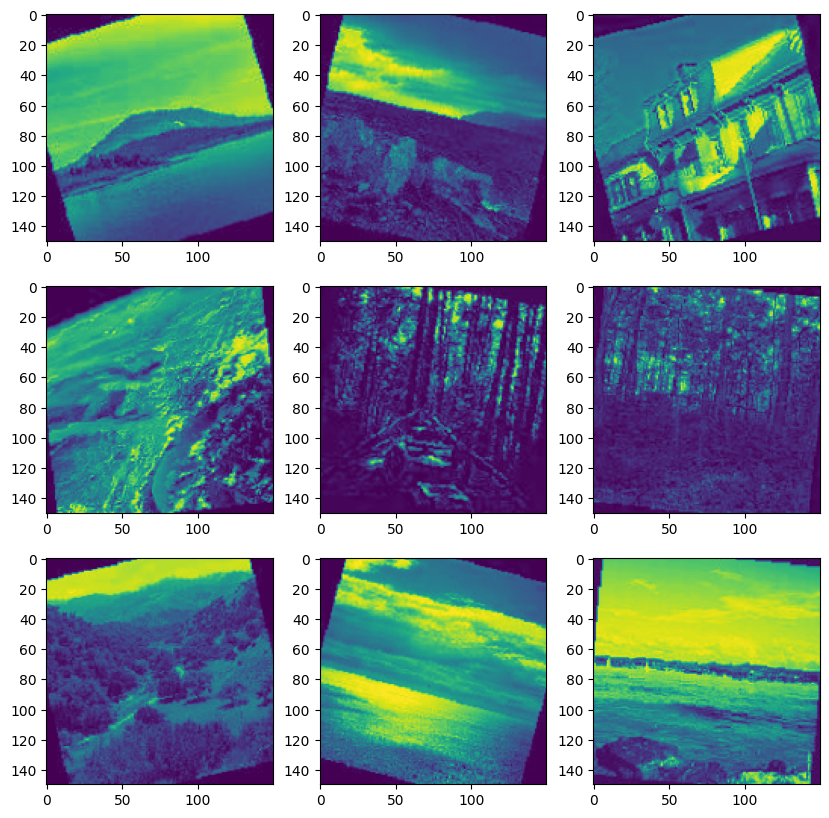

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(0,9):
    plt.subplot(331 + i)
    plt.imshow(images[i][0])
    #plt.title("\nLabel: ", labels[i]) # 이미지를 시각화

# ViT: Linformer

In [ ]:
"""
# linformer
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

# vit
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=6,
    transformer=efficient_transformer,
    channels=3,
).to(device)"""

'model = ViT(\n    dim=128,\n    image_size=224,\n    patch_size=32,\n    num_classes=6,\n    transformer=efficient_transformer,\n    channels=3,\n).to(device)'

In [ ]:
model = ViT(
    image_size = 224,
    patch_size = 16,
    num_classes = 6,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(trainloader):
        data = data.to(device)
        label = label.to(device).long()

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(trainloader)
        epoch_loss += loss / len(trainloader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in testloader:
            data = data.to(device)
            label = label.to(device).long()

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(testloader)
            epoch_val_loss += val_loss / len(testloader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/1816 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.9987 - acc: 0.6106 - val_loss : 0.7994 - val_acc: 0.7009



  0%|          | 0/1816 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6791 - acc: 0.7494 - val_loss : 0.6666 - val_acc: 0.7499



  0%|          | 0/1816 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.5229 - acc: 0.8078 - val_loss : 0.5939 - val_acc: 0.7804



  0%|          | 0/1816 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.4124 - acc: 0.8471 - val_loss : 0.5983 - val_acc: 0.7837



  0%|          | 0/1816 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.3246 - acc: 0.8794 - val_loss : 0.6339 - val_acc: 0.7930



  0%|          | 0/1816 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.2430 - acc: 0.9090 - val_loss : 0.6595 - val_acc: 0.7822



  0%|          | 0/1816 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.1958 - acc: 0.9279 - val_loss : 0.6183 - val_acc: 0.8044



  0%|          | 0/1816 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.1638 - acc: 0.9407 - val_loss : 0.7280 - val_acc: 0.7826



  0%|          | 0/1816 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# 모델을 평가 모드로 전환
model.eval()

# 예측 결과를 저장할 리스트 초기화
predictions = []

# testloader를 사용하여 테스트 데이터 예측
with torch.no_grad():
    for data in tqdm(testloader):  # 여기서 data는 데이터와 라벨을 포함하는 튜플이 될 수 있습니다.
        inputs = data[0].to(device)  # 데이터만 따로 추출하여 device에 할당
        output = model(inputs)
        preds = output.argmax(dim=1)
        predictions.extend(preds.cpu().numpy())

# submission.csv 파일 생성
submission_df = pd.DataFrame({'image_name': range(len(predictions)), 'label': predictions})
submission_df.to_csv('submission.csv', index=False)

print("Submission file has been created successfully!")


  0%|          | 0/455 [00:00<?, ?it/s]

Submission file has been created successfully!


# Vision Mamba

**vision mamba는 다운받을 수가 없다 ㅜㅜ**

In [ ]:
! pip install vision-mamba

In [ ]:
import torch
from vision_mamba import Vim

# Forward pass
x = torch.randn(1, 3, 224, 224)  # Input tensor with shape (batch_size, channels, height, width)

# Model
model = Vim(
    dim=256,  # Dimension of the transformer model
    heads=8,  # Number of attention heads
    dt_rank=32,  # Rank of the dynamic routing matrix
    dim_inner=256,  # Inner dimension of the transformer model
    d_state=256,  # Dimension of the state vector
    num_classes=1000,  # Number of output classes
    image_size=150,  # Size of the input image
    patch_size=16,  # Size of each image patch
    channels=3,  # Number of input channels
    dropout=0.1,  # Dropout rate
    depth=12,  # Depth of the transformer model
)

In [ ]:
device='cuda'

# 필요한 라이브러리를 불러옴
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

# Classifier 클래스를 인스턴스화하고 CUDA 디바이스에 로드함
#model = Classifier().to(device)

# Adam 최적화 알고리즘을 사용하여 옵티마이저를 설정함
optimizer = Adam(model.parameters(), lr=0.001)  # 초기 학습률 설정

# StepLR 학습률 스케줄러를 설정함
# 스텝 사이즈, 감소율 조정
scheduler = StepLR(optimizer, step_size=1, gamma=1/2)

# 에포크 조정
num_epochs = 10
for epoch in range(num_epochs):
    # 훈련 데이터에 대한 손실과 정확도를 계산하기 위한 변수를 초기화함
    train_loss = 0
    train_correct = 0
    train_samples = 0

    # 훈련 데이터셋을 배치 단위로 처리함
    for images, labels in trainloader:
        # 이미지와 레이블을 GPU로 전송함
        images = images.to(device)
        labels = labels.to(device).long()

        # 모델을 사용하여 예측을 수행함
        outputs = model(images)

        # 크로스 엔트로피 손실을 사용하여 분류 오류를 측정함
        loss = nn.CrossEntropyLoss()(outputs, labels)

        # 손실에 기초하여 모델의 파라미터를 업데이트함
        optimizer.zero_grad()  # 기울기 초기화
        loss.backward()  # 역전파 수행
        optimizer.step()  # 파라미터 업데이트

        # 통계를 업데이트함
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_samples += labels.size(0)

    # 에포크가 끝날 때마다 학습률을 업데이트함
    scheduler.step()

    # 검증 데이터에 대해 동일한 프로세스를 반복함. 단, 기울기 계산은 수행하지 않음
    val_loss = 0
    val_correct = 0
    val_samples = 0
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device).long()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_samples += labels.size(0)

    # 에포크마다 학습과 검증 결과를 출력함
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(trainloader):.4f}, Train Acc: {train_correct/train_samples:.4f}, Val Loss: {val_loss/len(testloader):.4f}, Val Acc: {val_correct/val_samples:.4f}")


# Swin Transformer

In [ ]:
! pip install transformers

In [ ]:
from transformers import SwinConfig, AutoImageProcessor, SwinForImageClassification, TrainingArguments, Trainer
from datasets import load_dataset, load_metric

In [ ]:
# upload dataset
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="./aug_output/")

Resolving data files:   0%|          | 0/25350 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 25350
    })
})


In [ ]:
configuration = SwinConfig()
configuration.num_labels = 10

feature_extractor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224",
                                                        label2id=label2id,
                                                        id2label=id2label,
                                                        ignore_mismatched_sizes = True,
                                                       )
model = SwinForImageClassification(configuration)

# Building Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, (3, 3), padding=1)  # 패딩 추가
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, (3, 3), padding=1)  # 필터 수 변경 및 패딩 추가
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)  # MaxPooling 추가
        self.conv3 = nn.Conv2d(128, 256, (3, 3), padding=1)  # 필터 수 변경 및 패딩 추가
        self.bn3 = nn.BatchNorm2d(256)
        self.dropout = nn.Dropout(0.5)  # 드롭아웃 확률을 0.5로 조정
        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6))  # 고정된 출력 크기를 위해 AdaptiveAvgPool2d 추가
        self.fc1 = nn.Linear(256 * 6 * 6, 512)  # 첫 번째 Fully Connected Layer 및 입력 차원 변경
        self.fc2 = nn.Linear(512, 128)  # 두 번째 Fully Connected Layer 차원 변경
        self.fc3 = nn.Linear(128, 6)  # 세 번째 Fully Connected Layer, 출력 노드 수 6개 유지

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # MaxPooling 적용
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # MaxPooling 적용
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # MaxPooling 적용
        x = self.adaptive_pool(x)  # AdaptiveAvgPool2d 적용
        x = x.view(-1, 256 * 6 * 6)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)  # 최종 출력
        return F.log_softmax(x, dim=1)


In [ ]:
"""import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, (3, 3))
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 256, (3, 3))
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 64, (3, 3))
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(0.1)  # 확률 0.5로 Dropout 추가
        self.fc1 = nn.Linear(64 * (150 - 6) * (150 - 6), 64)  # 첫 번째 Fully Connected Layer
        self.fc2 = nn.Linear(64, 64)  # 두 번째 Fully Connected Layer
        self.fc3 = nn.Linear(64, 6)  # 세 번째 Fully Connected Layer, 출력 노드 수를 6개로 변경

    def forward(self, x):
        x = self.dropout(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * (150 - 6) * (150 - 6))  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # 최종 출력
        return  F.log_softmax(x, dim=1)"""

In [ ]:
"""class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, (3, 3))
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)  # MaxPooling 추가

        self.conv2 = nn.Conv2d(64, 256, (3, 3))
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)  # MaxPooling 추가

        self.conv3 = nn.Conv2d(256, 64, (3, 3))
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)  # MaxPooling 추가

        self.dropout = nn.Dropout(0.1)  # 확률 0.5로 Dropout 추가

        # 풀링 후의 출력 크기를 계산하여 Linear 레이어의 입력 크기를 설정
        self.fc1 = nn.Linear(64 * 17 * 17, 64)  # 첫 번째 Fully Connected Layer
        self.fc2 = nn.Linear(64, 64)  # 두 번째 Fully Connected Layer
        self.fc3 = nn.Linear(64, 6)  # 세 번째 Fully Connected Layer, 출력 노드 수를 6개로 변경

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, 64 * 17 * 17)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # 최종 출력
        return F.log_softmax(x, dim=1)  # log_softmax 사용"""

# Model Training

In [ ]:
device='cuda'

# 필요한 라이브러리를 불러옴
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

# Classifier 클래스를 인스턴스화하고 CUDA 디바이스에 로드함
model = Classifier().to(device)

# Adam 최적화 알고리즘을 사용하여 옵티마이저를 설정함
optimizer = Adam(model.parameters(), lr=0.001)  # 초기 학습률 설정

# StepLR 학습률 스케줄러를 설정함
# 스텝 사이즈, 감소율 조정
scheduler = StepLR(optimizer, step_size=2, gamma=1/4)

# 에포크 조정
num_epochs = 30
for epoch in range(num_epochs):
    # 훈련 데이터에 대한 손실과 정확도를 계산하기 위한 변수를 초기화함
    train_loss = 0
    train_correct = 0
    train_samples = 0

    # 훈련 데이터셋을 배치 단위로 처리함
    for images, labels in trainloader:
        # 이미지와 레이블을 GPU로 전송함
        images = images.to(device)
        labels = labels.to(device).long()

        # 모델을 사용하여 예측을 수행함
        outputs = model(images)

        # 크로스 엔트로피 손실을 사용하여 분류 오류를 측정함
        loss = nn.CrossEntropyLoss()(outputs, labels)

        # 손실에 기초하여 모델의 파라미터를 업데이트함
        optimizer.zero_grad()  # 기울기 초기화
        loss.backward()  # 역전파 수행
        optimizer.step()  # 파라미터 업데이트

        # 통계를 업데이트함
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_samples += labels.size(0)

    # 에포크가 끝날 때마다 학습률을 업데이트함
    scheduler.step()

    # 검증 데이터에 대해 동일한 프로세스를 반복함. 단, 기울기 계산은 수행하지 않음
    val_loss = 0
    val_correct = 0
    val_samples = 0
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device).long()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_samples += labels.size(0)

    # 에포크마다 학습과 검증 결과를 출력함
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(trainloader):.4f}, Train Acc: {train_correct/train_samples:.4f}, Val Loss: {val_loss/len(testloader):.4f}, Val Acc: {val_correct/val_samples:.4f}")


Epoch [1/30], Train Loss: 1.2052, Train Acc: 0.5258, Val Loss: 1.0521, Val Acc: 0.5940
Epoch [2/30], Train Loss: 0.9759, Train Acc: 0.6362, Val Loss: 0.9042, Val Acc: 0.6720
Epoch [3/30], Train Loss: 0.7570, Train Acc: 0.7307, Val Loss: 0.7539, Val Acc: 0.7239
Epoch [4/30], Train Loss: 0.6850, Train Acc: 0.7571, Val Loss: 0.6871, Val Acc: 0.7525
Epoch [5/30], Train Loss: 0.6141, Train Acc: 0.7836, Val Loss: 0.6271, Val Acc: 0.7737
Epoch [6/30], Train Loss: 0.5882, Train Acc: 0.7931, Val Loss: 0.6075, Val Acc: 0.7838
Epoch [7/30], Train Loss: 0.5648, Train Acc: 0.8020, Val Loss: 0.6084, Val Acc: 0.7856
Epoch [8/30], Train Loss: 0.5567, Train Acc: 0.8023, Val Loss: 0.5882, Val Acc: 0.7979
Epoch [9/30], Train Loss: 0.5543, Train Acc: 0.8037, Val Loss: 0.5701, Val Acc: 0.7948
Epoch [10/30], Train Loss: 0.5587, Train Acc: 0.8021, Val Loss: 0.5851, Val Acc: 0.7895
Epoch [11/30], Train Loss: 0.5533, Train Acc: 0.8047, Val Loss: 0.5800, Val Acc: 0.7913
Epoch [12/30], Train Loss: 0.5473, Train 

KeyboardInterrupt: 